# Boat Recognition in Satellite Imagery  

#### Proposal by Russell Perry, May 2019

## The Data  

The Kaggle Dataset “Ships in Satellite Imagery” (https://www.kaggle.com/rhammell/ships-insatellite-imagery) is the primary source for this project, where the data is stored in easy-to access JSON format. The data consists of 4000 80x80 RGB images, 3000 of which contain land and sea, while 1000 contain boats. Image analysis will be performed to predict which images
contain boats and which do not, hoping for > 90% accuracy.

In [1]:
# typical imports. Pandas may or may not be used with this set.
import pandas as pd
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# open file, make data dictionary, close file
with open('shipsnet.json') as datafile:
    data_dict = json.load(datafile)

### Checking Data lengths, Peeking at data

In [3]:
# get keys and look at shape/counts of data
display(data_dict.keys())
for key in data_dict:
    print(key, 'length:', len(data_dict[key]))

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

data length: 4000
labels length: 4000
locations length: 4000
scene_ids length: 4000


In [4]:
# peek at data types
for key in data_dict:
    if type(data_dict[key][0]) == list:
        print(key, 'is nested list of type:', type(data_dict[key][0][0]))
    else:
        print(key, 'is list of type:', type(data_dict[key][0]))

data is nested list of type: <class 'int'>
labels is list of type: <class 'int'>
locations is nested list of type: <class 'float'>
scene_ids is list of type: <class 'str'>


In [5]:
# peek at format of scene_ids
for i in range(5):
    print(data_dict['scene_ids'][i])

20180708_180909_0f47
20170705_180816_103e
20180712_211331_0f06
20170609_180756_103a
20170515_180653_1007


### Data Validation, checking for consistant data types, ranges, and no null/NaN values

In [6]:
# check for other types in scene_ids
for i in data_dict['scene_ids']:
    if type(i) != str:
        print('missing scene_id')
        
# check for nan or out of range values in location nested list
for i in np.isnan(np.array(data_dict['locations']).flatten()):
    if i:
        print(i)
print("min location (lat):", np.min(np.array(data_dict['locations'])[:, 1]),
      "\nmax location (lat):", np.max(np.array(data_dict['locations'])[:, 1]),
      "\nmin location (lon):", np.min(np.array(data_dict['locations'])[:, 0]),
      "\nmax location (lon):", np.max(np.array(data_dict['locations'])[:, 0])
)



min location (lat): 33.629003320508104 
max location (lat): 37.9034617474773 
min location (lon): -122.67634727552148 
max location (lon): -117.90209155024934


The above are reasonable for latitude [-90, 90] and longitude [-180, 180] ranges.

In [8]:
# checking size range of pixel values
notfound = True

# checking for NaN values in the image data.
for image in data_dict['data']:
    # isnan(input) returns an array T/F values of the same size as input
    for i in np.isnan(image):
        if i:
            print('NaN values present.')

if notfound:
    print('No NaN values for pixels found.')
notfound = True

for image in data_dict['data']:
    for i in image:
        if (i < 0) or (i > 255):
            print("found a pixel value that's out of range:", i)
            notfound = False
            
if notfound:
    print('Pixels are all in proper range.')
notfound = True
    
# checking that labels make sense (ship or no-ship)
for i in data_dict['labels']:
    if (i != 0) and (i != 1):
        print('some label doesnt make sense:', i)
        
if notfound:
    print('All labels make sense (0 or 1).')

No NaN values for pixels found.
Pixels are all in proper range.
All labels make sense (0 or 1).


In [9]:
# Data has dimensions (4000, 19200), with 6400 data points for each color (rgb) in a row (known from metadata).
# Breaking it down into 4000 sets of three colors of 80 x 80 pixle images, transpose is to work with pyplot.imshow().
# casting all lists/nested lists to arrays.
data = np.reshape(data_dict['data'], (-1, 3, 80, 80)).transpose([0, 2, 3, 1])
labels = np.array(data_dict['labels'])
locations = np.array(data_dict['locations'])
scene_ids = np.array(data_dict['scene_ids'])

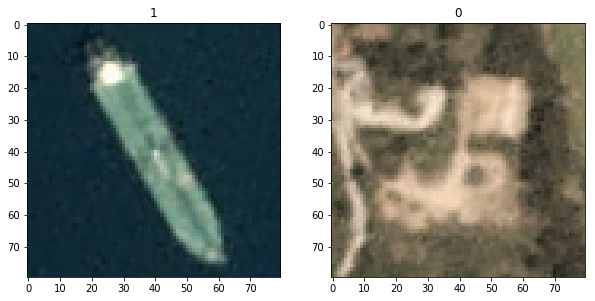

In [10]:
# display example images to prove feasability
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data[20])
ax[0].set_title(labels[20])
ax[1].imshow(data[-21])
ax[1].set_title(labels[-21])
plt.show()

The ML algorithm of choice for image recognition is a 2D convolutional deep learning network,
which the Keras library readily supports using as a sequential model.  

A convolution of the image is made against a smaller-sized kernel filter (a 2D weight
matrix), returning a dot product for each position, defined by the stride of the convolution. A
stride of one pixel would move the kernel by one matrix position at a time over the image i.e.
from position (i, j) to position (i+1, j); A two pixel stride would move the kernel by two matrix
positions. A feature matrix is the result, whose elements are the scalar dot product of the
kernel and image at each position.  

The feature matrix of dot product results is then pooled or subsampled by some
function, such as by maximum or average of an area of pixels, then run through another
convolution with another kernel, continuing the process. Pooling is done to save memory space
and speed up the process, for the end goal of a flat, 1-dimensional vector of weights results,
which can be run through a simple classification algorithm.  

This was the method of choice for multiple Kaggle kernels (user notebooks), and so is confirmed to work for this set. It can take RGB images of 80x80 pixels well.